In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Use BigQuery DataFrames to visualize COVID-19 data

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/googleapis/python-bigquery-dataframes/blob/main/notebooks/visualization/bq_dataframes_covid_line_graphs.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/colab-logo.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/googleapis/python-bigquery-dataframes/tree/main/notebooks/visualization/bq_dataframes_covid_line_graphs.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/github-logo.png" width="32" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/googleapis/python-bigquery-dataframes/tree/main/notebooks/visualization/bq_dataframes_covid_line_graphs.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
</table>

## Overview

The goal of this notebook is to demonstrate creating line graphs from a ~20 million-row BigQuery dataset using BigQuery DataFrames. We will first create a plain line graph using matplotlip, then we will downsample and download our data to create a graph with a line of best fit using seaborn.

If you're like me, during 2020 (and/or later years) you often found yourself looking at charts like [these](https://health.google.com/covid-19/open-data/explorer/statistics) visualizing COVID-19 cases over time. For our first graph, we're going to recreate one of those charts by filtering, summing, and then graphing COVID-19 data from the United States. BigQuery DataFrame's default integration with matplotlib will get us a satisfying result for this first graph.

For our second graph, though, we want to use a scatterplot with a line of best fit, something that matplotlib will not do for us automatically. So, we'll demonstrate how to downsample our data and use seaborn to make our plot. Our second graph will be of symptom-related search trends against new cases of COVID-19, so we'll see if searches for things like "cough" and "fever" are more common in the places and times where more new cases of COVID-19 occur.

### Dataset

This notebook uses the [BigQuery COVID-19 Open Data](https://pantheon.corp.google.com/marketplace/product/bigquery-public-datasets/covid19-open-data). In this dataset, each row represents a new observation of the COVID-19 situation in a particular time and place. We will use the "new_confirmed" column, which contains the number of new COVID-19 cases at each observation, along with the "search_trends_cough", "search_trends_fever", and "search_trends_bruise" columns, which are [Google Trends](https://trends.google.com/trends/) data for searches related to cough, fever, and bruises. In the first section of the notebook, we will also use the "country_code" and "date" columns to compile one data point per day for a particular country.

### Costs

This tutorial uses billable components of Google Cloud:

* BigQuery (compute)

Learn about [BigQuery compute pricing](https://cloud.google.com/bigquery/pricing#analysis_pricing_models),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

4. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [2]:
PROJECT_ID = ""  # @param {type:"string"}

#### Set the region

You can also change the `REGION` variable used by BigQuery. Learn more about [BigQuery regions](https://cloud.google.com/bigquery/docs/locations#supported_locations).

In [3]:
REGION = "US"  # @param {type: "string"}

Now we are ready to use BigQuery DataFrames!

## Visualization #1: Cases over time in the US

### Set up project and filter data

First, let's do project setup. We use options to tell BigQuery DataFrames what project and what region to use for our cloud computing.

In [1]:
import bigframes.pandas as bpd

# Note: The project option is not required in all environments.
# On BigQuery Studio, the project ID is automatically detected.
# bpd.options.bigquery.project = PROJECT_ID

# Note: The location option is not required.
# It defaults to the location of the first table or query
# passed to read_gbq(). For APIs where a location can't be
# auto-detected, the location defaults to the "US" location.
bpd.options.bigquery.location = REGION
# Improves performance by avoiding generating total row ordering
bpd.options.bigquery.ordering_mode = "partial"

Next, we read the data from a publicly available BigQuery dataset. This will take ~1 minute.

In [3]:
all_data = bpd.read_gbq("bigquery-public-data.covid19_open_data.covid19_open_data")

Using pandas syntax, we will select from our all_data input dataframe only those rows where the country_code is US. This is called row filtering.

In [4]:
usa_data = all_data[all_data["country_code"] == "US"]

We're only concerned with the date and the total number of confirmed cases for now, so select just those two columns as well.

In [7]:
usa_data = usa_data[["date", "new_confirmed"]]
usa_data.peek()

,date,new_confirmed
0,2020-10-08,189
1,2020-12-20,148
2,2021-01-16,2543
3,2020-08-15,933
4,2020-05-30,790


### Sum data

`usa_data.groupby("date")` will give us a groupby object that lets us perform operations on groups of rows with the same date. We call sum on that object to get the sum for each day. This process might be familiar to pandas users.

In [9]:
for key, group in usa_data.groupby("date"):
    print(key)
    print(group.sum(numeric_only=True))

2020-01-01


new_confirmed    0
dtype: Int64


2020-01-02


new_confirmed    0
dtype: Int64


2020-01-03


new_confirmed    0
dtype: Int64


2020-01-04


new_confirmed    0
dtype: Int64


2020-01-05


Requested cancellation for Query job 1e3ef3bb-c1dd-4c37-8921-42e4743f486a in location US...


KeyboardInterrupt: 

In [7]:
# numeric_only = True because we don't want to sum dates
new_cases_usa = usa_data.groupby("date").sum(numeric_only = True)

### Line graph

BigQuery DataFrames implements some plotting methods with the matplotlib backend. Use `DataFrame.plot.line()` to draw a simple line graph.

<Axes: xlabel='date', ylabel='New Cases'>

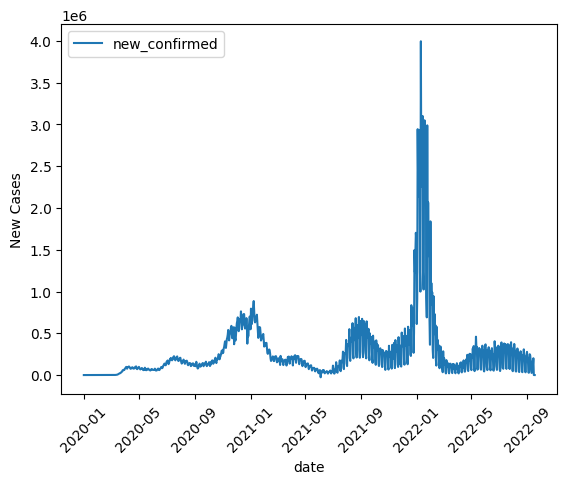

In [8]:
new_cases_usa.plot.line(
    rot=45,
    ylabel="New Cases",
)

## Visualization #2: Symptom-related searches compared to new cases

### Filter data

We're curious if searches for symptoms like "cough" and "fever" went up in the same times and places that new COVID-19 cases occured, compared to non-symptoms like "bruise." Let's plot searches vs. new cases to see if it looks like there's a correlation.

First, we select the new cases column and the search trends we're interested in.

In [55]:
regional_data = all_data[all_data["aggregation_level"] == 1]    # get only region level data,
symptom_data = regional_data[["location_key", "new_confirmed", "search_trends_cough", "search_trends_fever", "search_trends_bruise", "population", "date"]]

Not all rows have data for all of these columns, so let's select only the rows that do. Finally, lets add a new column capturing new confirmed cases as a percentage of area population.

In [ ]:
symptom_data = symptom_data.dropna()
symptom_data = symptom_data[symptom_data["new_confirmed"] > 0]
symptom_data["new_cases_percent_of_pop"] = (symptom_data["new_confirmed"]  / symptom_data["population"]) * 100


# remove impossible data points
symptom_data = symptom_data[(symptom_data["new_cases_percent_of_pop"] >= 0)]


In [ ]:
# group data up by week
weekly_data = symptom_data.groupby([symptom_data.location_key, symptom_data.date.dt.isocalendar().week]).agg({"new_cases_percent_of_pop": "sum", "search_trends_cough": "mean", "search_trends_fever": "mean", "search_trends_bruise": "mean"})

We want to use a line of best fit to make the correlation stand out. Matplotlib does not include a feature for lines of best fit, but seaborn, which is built on matplotlib, does.

BigQuery DataFrames does not currently integrate with seaborn by default. So we will demonstrate how to downsample and download a DataFrame, and use seaborn on the downloaded data.

### Graph with lines of best fit

We will now use seaborn to make the plots with the lines of best fit for cough, fever, and bruise. Note that since we're working with a local pandas dataframe, you could use any other Python library or technique you're familiar with, but we'll stick to seaborn for this notebook.

Seaborn will take a few minutes to calculate the lines. Since cough and fever are symptoms of COVID-19, but bruising isn't, we expect the slope of the line of best fit to be positive in the first two graphs, but not the third, indicating that there is a correlation between new COVID-19 cases and cough- and fever-related searches.

<Axes: >

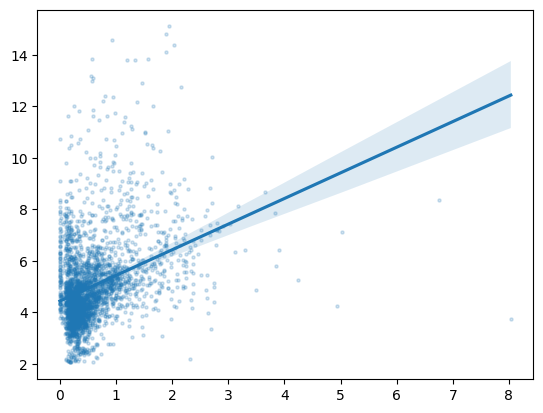

In [59]:
import seaborn as sns

# draw the graph. This might take ~30 seconds.
sns.regplot(x="new_cases_percent_of_pop", y="search_trends_cough", data=weekly_data, scatter_kws={'alpha': 0.2, "s" :5})

<Axes: >

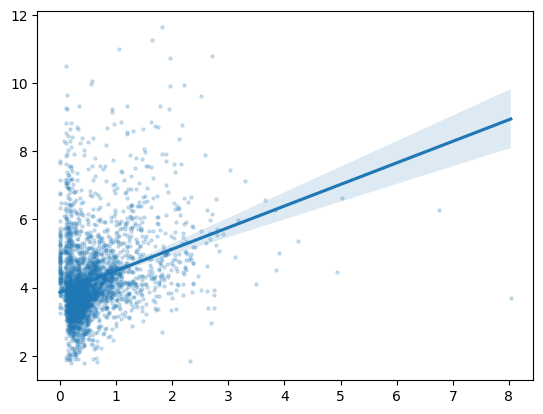

In [62]:
# similarly, for fever
sns.regplot(x="new_cases_percent_of_pop", y="search_trends_fever", data=weekly_data, scatter_kws={'alpha': 0.2, "s" :5})

<Axes: >

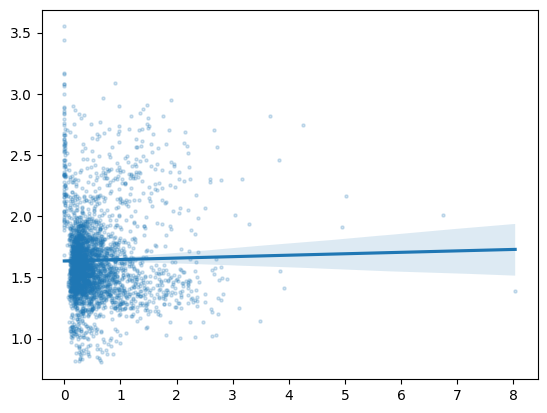

In [63]:
# similarly, for bruise
sns.regplot(
    x="new_cases_percent_of_pop",
    y="search_trends_bruise",
    data=weekly_data,
    scatter_kws={'alpha': 0.2, "s" :5}
)

We see that the slope of the line is positive in the graphs for cough and fever, but flat for bruise. That means that in places with increasing new cases of COVID-19, we saw increasing searches for cough and fever, but we didn't see increasing searches for unrelated symptoms like bruises. Interesting!

## Recap

We used matplotlib to draw a line graph of COVID-19 cases over time in the USA. Then, we used downsampling to download only a portion of the available data, used seaborn to plot lines of best fit to observe corellation between COVID-19 cases and searches for related versus unrelated symptoms.

Thank you for using BigQuery DataFrames!